## Preprocess and load our dataset
For preprocessing, convert all images in folders to array (224, 224, 3) and scale them. 70% of data is stored in train dataset array, 20% goes to validation dataset, and 10% goes to test dataset. Finally, convert all datas to float and one-hot-encode labels.   
For creating a CNN model, I refered to https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

In [1]:
# Import for loading and preprocessing

import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
from os import listdir

In [2]:
# Preprocess_input normalizes input in scale of [-1, +1]. You must apply same normalization in prediction.
# Devide the array by 127.5 and substract by 1
# Ref: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py (Line 45)

def preprocess_image(file_path):
    img = load_img(file_path, target_size=(224, 224)) 
    img = img_to_array(img)
    img = preprocess_input(img)
    
    return img

In [3]:
# Initialize a file path, class name as int, and lists/arrays for dataset
pictures_folder = "New Faces"

our_class = 0

train_data = []
train_label = []
valid_data = []
valid_label = []
test_data = []
test_label = []

In [4]:
# Iterate a folder ("New Faces") to folder ("User name") to user's 150 face images
# String beocomes file path by listdir
for folder_name in listdir(pictures_folder):
    if folder_name != '.DS_Store':  # for mac users
        folder_path = pictures_folder+'/'+folder_name  # create a path for the next folder to iterate
        
        index = 0  # reset index
        
        for file_name in listdir(folder_path):
            file_name = folder_path+'/'+file_name  # create a path for the files
            face_img = preprocess_image(file_name)  # scale and load images by the path
            
            size = len(listdir(folder_path))
            
            # 70% of data for training
            if index < size * 0.7: 
                train_data.append(face_img)
                train_label.append(our_class)
            
            # 20% of data for validation
            elif index < size * 0.9:
                valid_data.append(face_img)
                valid_label.append(our_class)
            
            # 10% of data for testing (not validation)
            else:
                test_data.append(face_img)
                test_label.append(our_class)
            
            index += 1  # increment index
        
        # Change class name since it moves to another folder
        our_class += 1

In [5]:
# Convert the list to numpy arrays of float
train_data = np.array(train_data).astype('float32')
valid_data = np.array(valid_data).astype('float32')
test_data = np.array(test_data).astype('float32')

# One-hot-encode labels for 'crosscategorical_entropy' loss function
train_label = to_categorical(train_label)
valid_label = to_categorical(valid_label)
test_label = to_categorical(test_label)

#train_data.shape

## Load pre-trained model
Import VGG16 from keras-applications and load the model (CNN model).   
Input shape is (224, 224, 3) that is size of images in our dataset.   
Please refer to https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

In [6]:
import keras
from keras.applications import vgg16
from keras.models import Model
from keras.layers import Flatten

# The size of images in our dataset
input_shape = (224, 224, 3)

# Load VGG16 model
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)
# Build the model
output = vgg.layers[-1].output
output = Flatten()(output)
vgg_model = Model(vgg.input, output)

# Freeze all layers in the base model by setting trainable = False
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

2022-05-04 19:41:12.561033: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Optional: print the detail of layers if you want

import pandas as pd
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

## Build a model with the pre-trained model
The layered architecture of deep learning model allows us to utilize a pre-trained network such as VGG16 without the final layer as a fixed feature extractor for the new task.   
For feature extracting, add VGG model as layers and other layers for output to a sequentail model.   
   
Loss is 0, and accuracy is 1

In [8]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

model = Sequential()
model.add(vgg_model)  # the pre-trained model
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='sigmoid'))  # output layer

# Configure the learning process via the compilation method
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# Display the model              
model.summary()             

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 25088)             14714688  
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 27,824,451
Trainable params: 13,109,763
No

In [9]:
from keras.callbacks import EarlyStopping

# Initialize the callback and add it to a list
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

callback_list = [es]

In [10]:
# Fit the models and apply the callback with its loss and the accuracy of each epoch
history = model.fit(train_data, train_label, batch_size=10, epochs=20, steps_per_epoch=31, 
                    callbacks=callback_list, validation_data=(valid_data, valid_label), shuffle=True)

Epoch 1/20
31/31 [==============================] - 58s 2s/step - loss: 4.9229 - accuracy: 0.9032 - val_loss: 0.7220 - val_accuracy: 0.9889
Epoch 2/20
31/31 [==============================] - 54s 2s/step - loss: 6.0284e-06 - accuracy: 1.0000 - val_loss: 0.7044 - val_accuracy: 0.9889
Epoch 3/20
31/31 [==============================] - 53s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.6842 - val_accuracy: 0.9889
Epoch 4/20
31/31 [==============================] - 53s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.6828 - val_accuracy: 0.9889
Epoch 5/20
31/31 [==============================] - 52s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.6827 - val_accuracy: 0.9889
Epoch 6/20
31/31 [==============================] - 53s 2s/step - loss: 3.9085e-10 - accuracy: 1.0000 - val_loss: 0.6824 - val_accuracy: 0.9889
Epoch 7/20
31/31 [==============================] - 52s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.6815 - val_accuracy: 0.9

In [11]:
# Saved in the same folder. It can be loaded anytime by load_model(path_name) function
model.save('fe_model' + '.h5')

In [12]:
# Load the saved model
from tensorflow import keras
our_model = keras.models.load_model('fe_model.h5')

# Print the scores
scores = our_model.evaluate(test_data, test_label, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

2/2 [==============================] - 6s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000
Test loss: 0.0
Test accuracy: 1.0


## Predict on test data
Our dataset has three classes. It uses 'np.argmax' to get the result from the one-hot encoded label.

In [13]:
# The name of classes
name = ['Jacob', 'Jake', 'Toxmin']

# The index of images to test
tester = [0, 17, 32]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


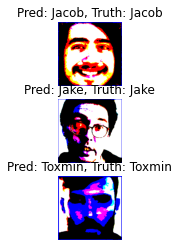

In [14]:
f, axarr = plt.subplots(3, 1)  # it is displayed as 3*1 matrix 

for i, num in enumerate(tester):  # iterate the list of idex
    
    # Get the array of the probabilties of each class (0 to 2)
    predict_array = our_model.predict(test_data[[num],:])

    # Index of the max value (the name of the class with the highest probability)
    prediction = np.argmax(predict_array)
    truth = np.argmax(test_label[num])
    
    # Print the image with title (Prediction and Ground Truth)
    axarr[i].set_axis_off()
    axarr[i].set_title('Pred: {}, Truth: {}'.format(name[prediction], name[truth]))
    axarr[i].imshow(test_data[num])  # Needs reshape so that it can use imshow